# Pagerank figure
This file filters through the modularity data to find the pagerank of a specified cell type within it's module at various resolutions. This is then plotted with the cluster size of the module it is in at the resolution. 

This code was written by Rhessa Weber Langstaff based off of code from Prof. Gabrielle J Gutierrez.

In [9]:
# import important stuff here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
from neuprint import fetch_simple_connections, Client
import networkx as nx


auth_token_file = open("flybrain.auth.txt", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + 'v1.2.1', token=auth_token)
except:
    np_client = None

In [10]:
from neuprint import fetch_simple_connections

def importance(mod_df, res, clu_id):
    """
    This function takes a cell type name, a modularity dataframe, and the resolutions.
    It returns the pagerank, in-degree, & in-degree centrality of the cell types in the cluster across resolutions.
    """
    # get the ids of the neurons in the cluster key
    mod_ids = mod_df[mod_df[res]==clu_id]['id'].tolist()


    if len(mod_ids)<=1:
        pg = [[]]
        in_deg = [[]]
        in_deg_centr = [[]]
        return pg, in_deg, in_deg_centr
        #return '1 or fewer neurons in this cluster'
    
    # fetch simple connections among neurons in chosen cluster
    clu_connectome = fetch_simple_connections(mod_ids, mod_ids, min_weight=3)
    
    # replace None with string 'None' to allow it to be a node in the graph
    clu_connectome = clu_connectome.fillna('None')
    
    # group by celltype and count the number of connections
    clu_type_connectome = clu_connectome[['type_pre','type_post','weight']].groupby(['type_pre','type_post']).sum()
    
    # let's threshold?
    clu_type_connectome = clu_type_connectome[clu_type_connectome['weight']>1]
    
    # reset the index to make the dataframe easier to work with
    clu_type_connectome = clu_type_connectome.reset_index()
    
    # make a directed graph from the dataframe
    G = nx.from_pandas_edgelist(clu_type_connectome, 'type_pre', 'type_post', edge_attr='weight', create_using=nx.DiGraph())
    
    # sorted dictionary of the in-degrees of the nodes in the graph
    in_deg = G.in_degree(weight='weight')
    in_deg = sorted(dict(in_deg).items(), key=lambda x: x[1], reverse=True)

    # sorted dictionary of the in-degree centrality of the nodes in the graph
    in_deg_centr = nx.in_degree_centrality(G)
    in_deg_centr = sorted(in_deg_centr.items(), key=lambda x: x[1], reverse=True)

    # get the importance of the cell type in the cluster
    pg = nx.pagerank(G)
    pg = sorted(pg.items(), key=lambda x: x[1], reverse=True)
    
    return pg, in_deg, in_deg_centr

In [11]:
# load the oviINr input connectome
ovi_in = pd.read_csv('oviIN/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv')
ovi_in

,id,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,...,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
0,1003215282,1,1,1,1,1,1,1,CL229_R,CL229,...,Traced,False,Roughly traced,PDM19,301.0,"[23044, 14981, 11600]","{'INP': {'pre': 87, 'post': 351, 'downstream':...",NaN,"['EPA(R)', 'GOR(R)', 'IB', 'ICL(R)', 'INP', 'S...","['GOR(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
1,1005952640,2,2,1,1,2,2,2,IB058_R,IB058,...,Traced,False,Roughly traced,PVL20,NaN,NaN,"{'INP': {'pre': 464, 'post': 1327, 'downstream...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S..."
2,1006928515,3,1,1,1,3,3,3,CL300_R,CL300,...,Traced,False,Roughly traced,PVL13,236.0,"[12083, 10523, 16816]","{'INP': {'pre': 79, 'post': 126, 'downstream':...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
3,1007260806,4,2,1,1,4,4,4,CL301_R,CL301,...,Traced,False,Roughly traced,PVL13,236.0,"[13524, 10108, 16480]","{'INP': {'pre': 40, 'post': 128, 'downstream':...",NaN,"['GOR(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['IB', 'ICL(R)', 'INP', 'PLP(R)', 'SCL(R)', 'S..."
4,1008024276,5,3,2,2,5,5,5,FB5N_R,FB5N,...,Traced,False,Roughly traced,AVM08,472.5,"[19178, 29711, 37312]","{'SNP(L)': {'post': 5, 'upstream': 5, 'mito': ...",SMPCREFB5_4,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,987273073,2507,3,8,8,409,604,629,(PVL05)_L,NaN,...,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(R)': {'pre': 65, 'post': 52, 'downstream...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'..."
2507,987842109,2508,3,9,23,533,780,815,NaN,NaN,...,Orphan,NaN,Orphan hotknife,NaN,NaN,NaN,"{'SNP(R)': {'pre': 2, 'post': 13, 'downstream'...",NaN,"['SMP(R)', 'SNP(R)']","['SMP(R)', 'SNP(R)']"
2508,988567837,2509,2,3,4,16,58,63,FB4G_R,FB4G,...,Traced,False,Roughly traced,AVM08,NaN,NaN,"{'SNP(R)': {'pre': 6, 'post': 73, 'downstream'...",CRELALFB4_3,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
2509,988909130,2510,2,3,4,389,559,572,FB5V_R,FB5V,...,Traced,False,Roughly traced,AVM10,296.5,"[13226, 32024, 18600]","{'SNP(R)': {'pre': 1, 'post': 28, 'downstream'...",CRELALFB5,"['AB(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX',...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."


In [12]:
# the resolutions
resos = ['0.0','0.05','0.1','0.5','0.75','1.0']

In [13]:
def get_pagerank_dataframe(celltype, cluster, mod_df, resolutions):
    cluster = mod_df[mod_df['0.0']==cluster]
    cluster = cluster[['id','0.0','0.05','0.1','0.5','0.75','1.0', 'celltype']]
    # get the cluster rows for a neuron that we want to analyze
    cluster_row = cluster[cluster['celltype']==celltype]
    cluster_row_dict = cluster_row[resolutions].mode(axis=0).to_dict('records')[0]
    pg_rank_dict = {}
    pg_cluster_size = {}
    for i in resos:
        clu_id = cluster_row_dict[i]
        pg, in_deg, in_deg_c = importance(cluster, i, clu_id)
        if len(pg)<=1:
            pg_rank_dict[i] = None
            pg_cluster_size[i] = 0
            continue
        index = pg.index(next(filter(lambda x: x[0] == celltype, pg)))
        pg_rank_dict[i] = index
        pg_cluster_size[i] = len(pg)

    return pg_rank_dict, pg_cluster_size

In [14]:
# get the pagerank dictionary for FS1A in cluster 3
pg_rank, cluster_size = get_pagerank_dataframe('FS1A', 3, ovi_in, resos)
pg_rank_IB, cluster_size_IB = get_pagerank_dataframe('IB017', 2, ovi_in, resos)
pg_rank_SMP, cluster_size_SMP = get_pagerank_dataframe('SMP052', 1, ovi_in, resos)
# Create a dataframe to add pagerank values
pg_df = pd.DataFrame()
pg_df['FS1A'] = pg_rank
pg_df['IB017'] = pg_rank_IB
pg_df['SMP052'] = pg_rank_SMP

pg_df


,FS1A,IB017,SMP052
0.0,1,136.0,6
0.05,0,79.0,6
0.1,0,69.0,0
0.5,0,2.0,2
0.75,0,2.0,2
1.0,0,NaN,0


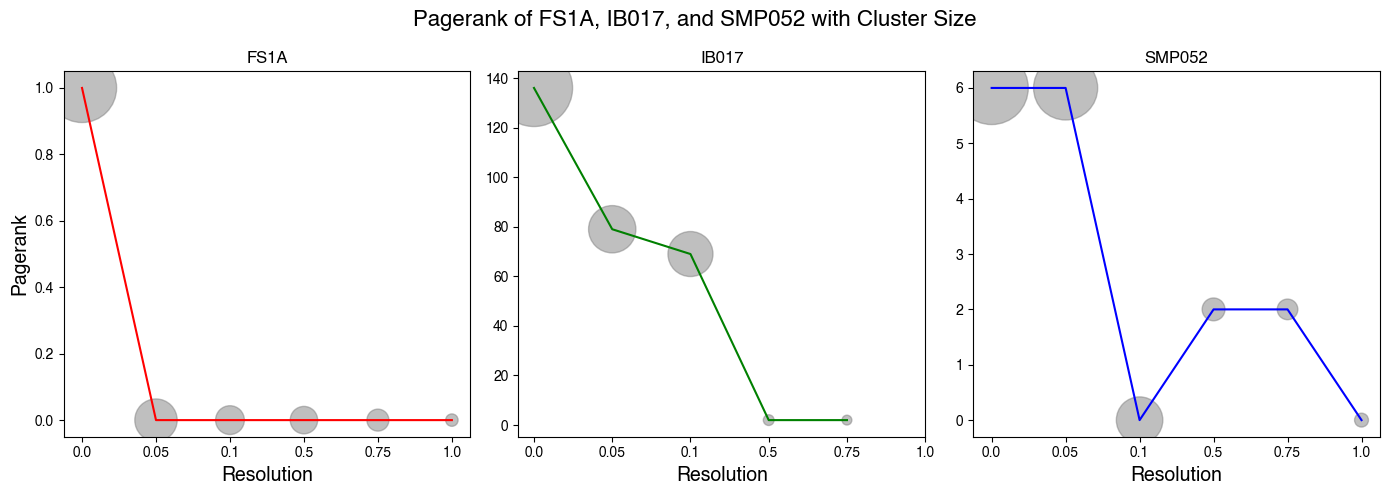

In [19]:
# plot the pagerank dataframe
fig, ax = plt.subplots(1, 3, figsize=(14,5), tight_layout=True)
plt.suptitle('Pagerank of FS1A, IB017, and SMP052 with Cluster Size', fontsize=16)

ax[0].plot(pg_df['FS1A'], label='FS1A', color='r')
ax[1].plot(pg_df['IB017'], label='IB017', color='g')
ax[2].plot(pg_df['SMP052'], label='SMP052', color='b')

ax[0].scatter(pg_df.index, pg_df['FS1A'], s=[i*10 for i in cluster_size.values()], color='grey', alpha=0.5)
ax[1].scatter(pg_df.index, pg_df['IB017'], s=[i*10 for i in cluster_size_IB.values()], color='grey', alpha=0.5)
ax[2].scatter(pg_df.index, pg_df['SMP052'], s=[i*10 for i in cluster_size_SMP.values()], color='grey', alpha=0.5)

ax[1].scatter([],[], s=100, color='grey', label='Cluster Size')

ax[0].set_ylabel('Pagerank', fontsize=14)

for i in range(3):
    ax[i].set_title(pg_df.columns[i])
    ax[i].set_xlabel('Resolution', fontsize=14)
    ax[i].set_xticks(np.arange(len(resos)))
    ax[i].set_xticklabels(resos)

In [23]:
# Save figure as svg
fig.savefig('pagerankfig_all.svg', format='svg')


In [22]:
# Save figure as pdf
fig.savefig('pagerankfig_all.pdf', format='pdf', bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


Text(0.5, 1.0, 'Pagerank of IB017')

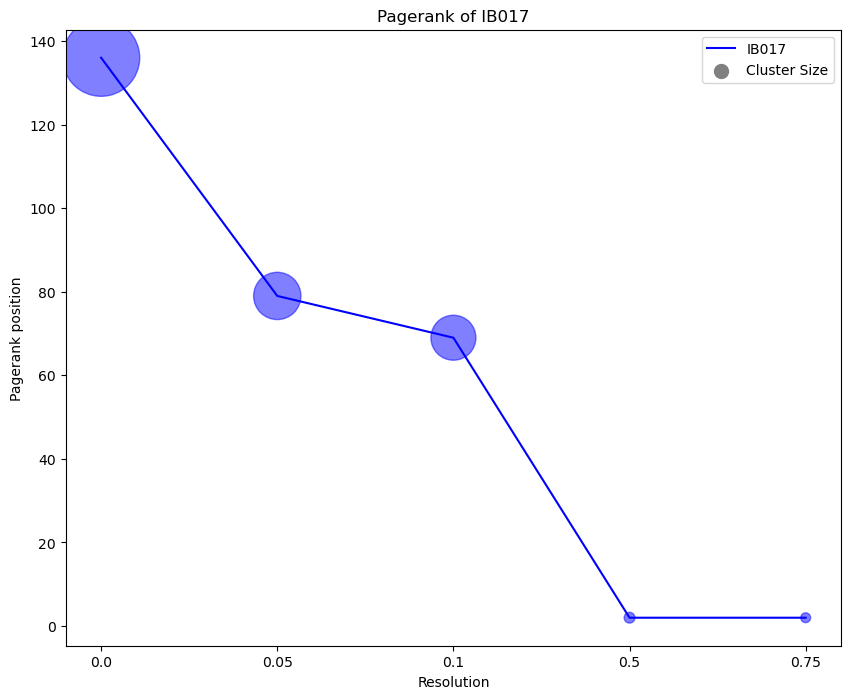

In [8]:
# plot IB017
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(pg_df.index, pg_df['IB017'], label='IB017', color='blue')
ax.scatter(pg_df.index, pg_df['IB017'], s=[i*10 for i in cluster_size_IB.values()], color='blue', alpha=0.5)

ax.scatter([],[], s=100, color='grey', label='Cluster Size')

ax.legend()
ax.set_xlabel('Resolution')
ax.set_ylabel('Pagerank position')
ax.set_title('Pagerank of IB017')

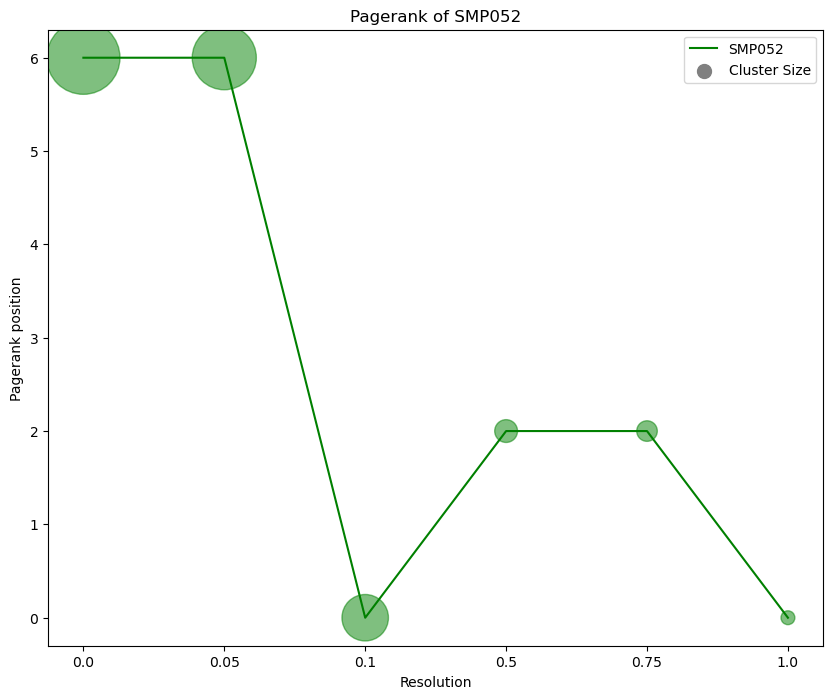

In [9]:
# plot SMP052
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(pg_df.index, pg_df['SMP052'], label='SMP052', color='green')
ax.scatter(pg_df.index, pg_df['SMP052'], s=[i*10 for i in cluster_size_SMP.values()], color='green', alpha=0.5)

ax.scatter([],[], s=100, color='grey', label='Cluster Size')

ax.legend()
ax.set_xlabel('Resolution')
ax.set_ylabel('Pagerank position')
ax.set_title('Pagerank of SMP052')
plt.show()